# Definindo o problema de negócio

O objetivo é definirmos a qualidade de um vinho branco baseado em suas caracteristicas 'physicochemical'. Os vinhos possuem uma qualidade que varia entre 0 e 10, possuindo valores continuos. Sendo assim a variavel target será convertida para qualitativa.

Qualidade >= 6.5 -> Bom

Qualidade < 6.5  -> Ruim

    -- Problema de Negócio
       Com os resultados de qualidade é possível melhorar a distribuição logistica e a precificação dos vinhos. Ainda é possível descartar vinhos de baixa qualidade ou reutilizar em outros processos industriais se possível.
       É esperado que os resultados auxiliem na tomada de decisão sobre o que fazer com um vinho de menor qualidade que o esperado. Uma das abordagens sugeridas é não enviar esse produto para o mercado de trabalho, visto que o cliente leal a empresa espera um nivel de qualidade que se não for atendido pode levar a perda de um cliente.
       Uma segunda abordagem seria identificar o por quê do produto estar possuindo uma qualidade inferior aos outros, pois pode tratar-se de um defeito em maquinas industriais, que minimanente causa impacto na qualidade do vinho.
       
       É esperado atingir uma acurácia de 85% com precisão de no minimo 70% para qualquer das classes de saida.
       
Dataset 01: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 

Dataset 02: https://archive.ics.uci.edu/ml/datasets/wine+quality       
       
### Variáveis da base
O que cada uma das varíaveis presente representa:

fixed acidity (apenas ácido tartárico): O ácido tartárico, facilmente encontrado em uvas e na sua fermentação. Aumenta a ácidez e a longevidade do vinho.

volatile acidity (apenas ácido acético): Associado ao gosto e principalmente ao cheiro de vinagre, também relacionado a bactérias e a oxidação. Níveis elevados desse ácido podem não ser desejados.

citric acid (apenas ácido cítrico): Uvas que crescem em ambientes mais quentes normalmente são menos ácidos. O ácido cítrico, normalmente é adicionado no processo de fermentação para aumentar a ácidez do vinho. Elevados nível de ácido cítrico podem contribuir para a geração de bactérias não desejadas no vinho.

residual sugar: Quantidade de açucar que permanece após a fermentação. Diretamente ligado a classificação do vinho, normalmente dividido em: Bone Dry (0-1 G/L), Dry (0-17 G/L), Off-Dry(17-35 G/L, Medium-Sweet (35-120 G/L), Sweet(120 G/L +).

chlorides (Cloreto de sódio): Basicamente a quantidade de sal no vinho. Quantidades elevadas podem gerar um vinho mais salgado.

free sulfur dioxide: Protege o vinho de oxidação e deterioração, porém em grandes quantidades pode gerar um sabor amargo/metálico/queimado. Quanto maior for o pH do vinho menos efetivo vai ser esse reagente. Produzido naturalmente no processo de fermentação.

total sulfur dioxide (free sulfur dioxide + bound sulfur dioxide): Quantidade total de dióxido sulfúrico no vinho, todo o dióxido que estiver atrelado a alguma molécula não serve de proteção ao vinho. Grandes quantidades podem gerar um odor de podre.

density: A densidade do vinho esta relacionada com o seu plantio, quanto maior a densidade menor a sua qualidade, isso se da pois as videiras irão dividir os nutrientes no solo.

pH: Descreve o quão acido é um vinho, possuindo uma escala de 0 a 14, onde 0 é muito acido e 14 se forma uma base. Os vinhos possuem pH entre 3 e 4.

sulphates: Atua como antioxidante no vinho, reduzindo a sua oxidação e criação de bacterias. Os vinhos brancos não possuem antioxidantes naturais sendo assim é necessário doses maiores de SO2 (dioxido de enxofre).

alcohol: Diretamente ligado a qualidade do vinho a tendência é que vinhos de maior qualidade possuam maior teor alcolico, o que nem sempre se comprova.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import imblearn
import os
import pickle
import shap

from pathlib import Path
from scipy import stats
from scipy.stats import norm
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from collections import Counter
from imblearn.over_sampling import SMOTE

%matplotlib inline

# Analise Exploratoria

## Analise Exploratoria - Sem Processamento

In [2]:
wines = pd.read_csv('Data/winequality-white.csv', sep = ';')

In [3]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Analisando algumas variaveis, percebemos que o 'residual sugar' médio dessa base é 6.39 g/l e o maximo 65.80 g/l (outlier), indicando que a nossa base não possui vinhos muito doces. Algumas colunas como chlorides, free sulfur dioxide e total sulfur dioxide possuem alguns valores muito altos, possivelmente outliers. O pH médio é de 3.18 com no maximo 3.82, indicando que essa base não possui altos niveis de pH. O nivel de alcool nessa base claramente não é muito alto, visto que a  média é de 10.51 indicando vinhos de baixo teor alcolico. Porém observando o Q3 (75%) é perceptivel que alguns vinhos possui um teor alcolico significativo e com o valor maximo possuindo alto valor alcolico, possivelmente um outlier.

In [4]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
wines.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [6]:
# Verificando se contem valor NA no dataset
wines.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
'''
    Função do repositorio: https://gist.github.com/anisayari/2d54c43044d7bb1b29c72c832a0fb1d8#file-reduce_mem_usage-py
    Auxilia na redução de memoria do dataframe, adaptando os tipos de cada variavel.
'''
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [8]:
#wines = reduce_mem_usage(wines)

Conforme analisado a redução do uso de memoria trouxe consequencias significativas para o modelo, assim será descartada a sua utilização.

In [9]:
# Verificando se foi alterado o valor de alguma variavel por engano
#wines.describe()

In [10]:
wines.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


É perceptivel que as variaveis com maior correlação são:  'fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'density' e 'alchohol'. Dessa forma as outras variaveis não possuem grande relevância para a variavel target 'quality'.

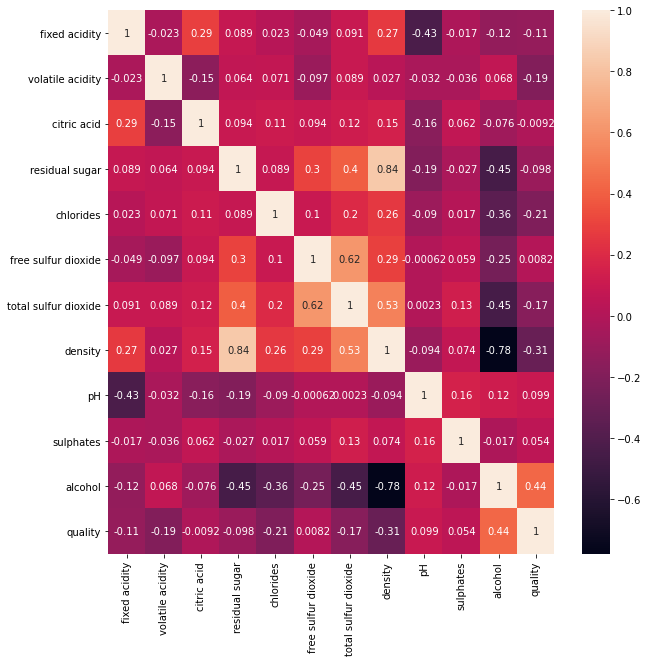

In [11]:
plt.figure(figsize = (10, 10))
sns.heatmap(wines.corr(), annot =  True)
plt.show()

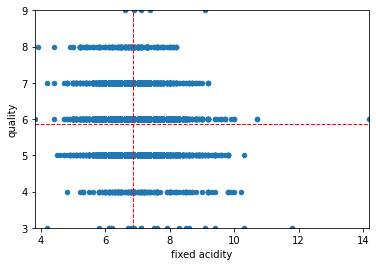

In [12]:
# Definindo range de X e Y
x_range = [wines['fixed acidity'].min(), wines['fixed acidity'].max()]
y_range = [wines['quality'].min(), wines['quality'].max()]

# Scatter plot de X e Y
scatter_plot = wines.plot(kind = 'scatter', x = 'fixed acidity', y = 'quality', xlim = x_range, ylim = y_range)

# Traçar linha da media de X e Y
meanY = scatter_plot.plot(x_range, [wines['quality'].mean(), wines['quality'].mean()], '--', color = 'red', linewidth = 1)
meanX = scatter_plot.plot([wines['fixed acidity'].mean(), wines['fixed acidity'].mean()], y_range, '--', color = 'red', linewidth = 1)

In [13]:
def scatter_plot_conjunto(data, columns, target):
    # Definindo range de Y
    y_range = [data[target].min(), data[target].max()]
    
    for column in columns:
        if target != column:
            # Definindo range de X
            x_range = [data[column].min(), data[column].max()]
            
            # Scatter plot de X e Y
            scatter_plot = data.plot(kind = 'scatter', x = column, y = target, xlim = x_range, ylim = y_range)
            
            # Traçar linha da media de X e Y
            meanX = scatter_plot.plot(x_range, [data[target].mean(), data[target].mean()], '--', color = 'red', linewidth = 1)
            meanY = scatter_plot.plot([data[column].mean(), data[column].mean()], y_range, '--', color = 'red', linewidth = 1)

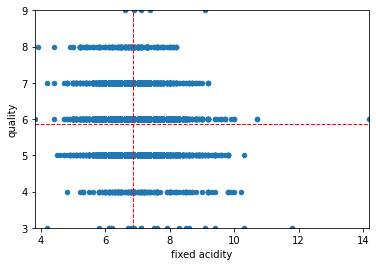

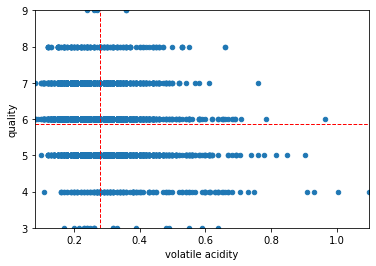

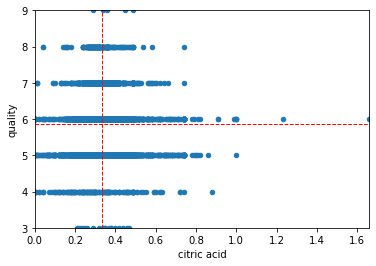

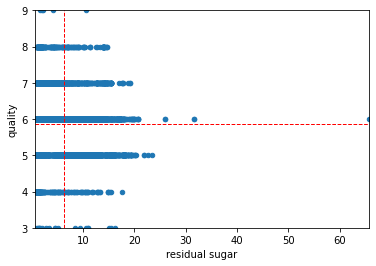

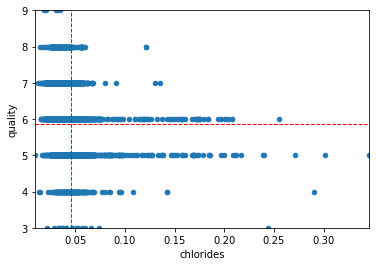

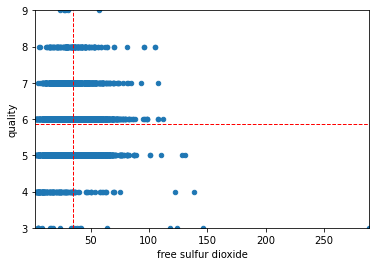

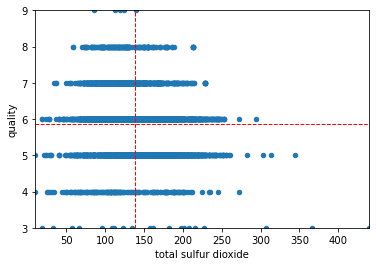

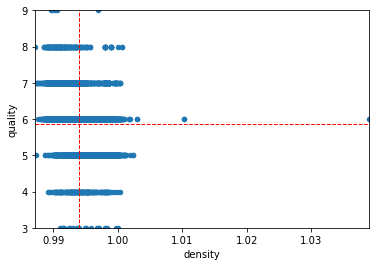

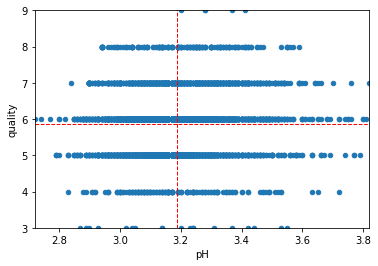

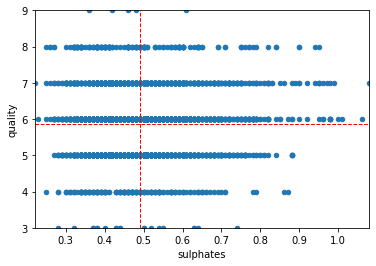

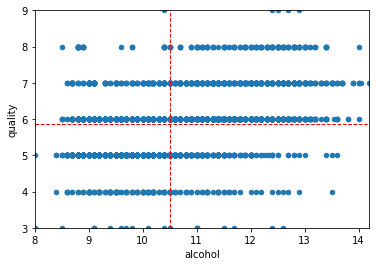

In [14]:
columns = wines.keys()
scatter_plot_conjunto(wines, columns, 'quality')

## Avaliando MultiColinearidade

In [15]:
X = wines.iloc[:, :-1]
y = wines['quality'].values

corr = np.corrcoef(X, rowvar = 0)
eigenvalues, eigenvectors = np.linalg.eig(corr)

Procurando pelo menor valor gerado no eigenvalues encontramos na posição 1 o valor 0.02064. Assim precisamos buscar essa posição no auto vetor para descobrir os valores com possivel multicolinearidade.

In [16]:
print(eigenvalues)

[3.22225389 0.02064909 1.57523993 0.28948714 0.41414367 1.22167134
 0.59935848 0.72659802 0.93874151 0.97333458 1.01852235]


Avaliando os valores na lista de auto vetores. Percebe-se que os valores que mais se destacam estão nas posições 0, 3, 7, 8 e 10. Esses valores se destacam por estarem muito altos em relação aos outros, principalmente posição 3, 7 e 10.

In [17]:
print(eigenvectors[:, 1])

[-0.17129048 -0.01705666 -0.00972112 -0.49022593 -0.02539945  0.03090844
 -0.03556095  0.75977937 -0.1411972  -0.04183284  0.35796133]


Primeiramente é exibido as variaveis com os valores que mais se destacaram, após é exibido com os valores que tiveram um destaque menor. Avaliamos que as variaveis 'density', 'residual sugar' e 'alcohol' são muito bem representadas pela variavel 'density', então pode ser recomendado a remoção das outras duas mantendo somente 'density'. Essa relação pode ser bem visualizada no mapa de calor da correção entre as variaveis.

In [18]:
print(columns[3], columns[7], columns[10])

residual sugar density alcohol


Avaliando a correlação entre as variaveis para ver qual se destaca entre as suas correlações, percebe que 'density' continua sendo a que melhor representa 'residual sugar' e 'alcohol'. Porém a variavel 'fixed acidity'apresentou uma boa representatividade sobre a variavel 'pH'. Pode ser uma boa ideia remover a variavel pH do dataset também.

Assim as variaveis 'fixed acidity', 'residual sugar', 'density', 'pH' e 'alcohol' poderiam ser resumidas para 'density' e 'fixed acidity'.

In [19]:
print(columns[0], columns[3], columns[7], columns[8], columns[10])

fixed acidity residual sugar density pH alcohol


Para ter uma maior certeza sobre os resultados acima podemos montar um scatter plot para ver a representação dos pontos. Como analisado nos graficos abaixo essa tendência da representatividade das variaives é comprovada. Porém, deve-se ficar atento a variavel 'density' e 'residual sugar', pois diferente das outras variaveis a sua representatividade não parace ser tão forte, podendo ter sido puxada por um outlier identificado. Vale um teste de remoção do outlier para testar a nova  correção entre as variaveis.

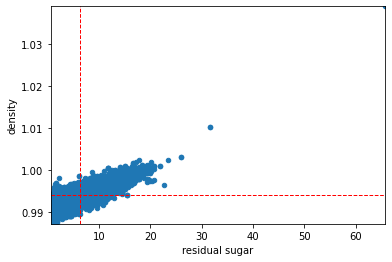

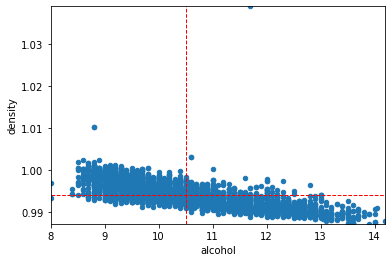

In [20]:
scatter_plot_conjunto(wines, ['residual sugar', 'alcohol'], 'density')

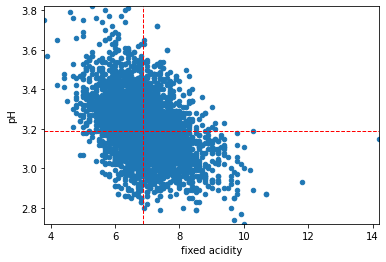

In [21]:
scatter_plot_conjunto(wines, ['fixed acidity'], 'pH')

In [22]:
def boxplot_plot_conjunto(data, columns, target):
    for column in columns:
        if column != target:
            sns.boxplot(x = target, y = column, data = data)

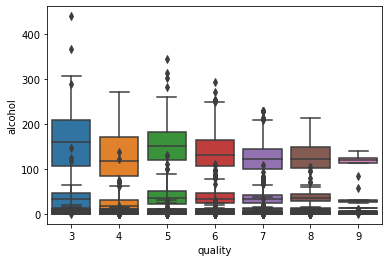

In [23]:
boxplot_plot_conjunto(wines, columns, 'quality')

In [24]:
print(columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


# Pre-Processamento

## Detectando e Removendo Outliers

Primeiramente para removermos outliers precisamos entender alguns detalhes sobre o nosso dataset. Entender se as suas variaives seguem uma distribuição normal Gaussiana. Para isso podemos utilizar o calculo de skewness, valores que distuarem muito de -1 e 1 podem ser ditos que não seguem uma distribuição normal Gaussiana.
Como analisado abaixo possuimos algumas variaveis que não seguem a distribuição normal, como por exemplo 'volatile acidity', 'citric acid', 'chlorides' e 'free sulfur dioxide'.

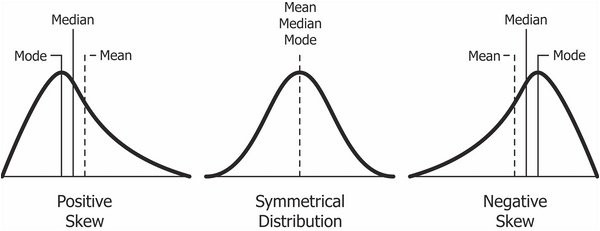

In [25]:
print(wines[columns].skew())

fixed acidity           0.647751
volatile acidity        1.576980
citric acid             1.281920
residual sugar          1.077094
chlorides               5.023331
free sulfur dioxide     1.406745
total sulfur dioxide    0.390710
density                 0.977773
pH                      0.457783
sulphates               0.977194
alcohol                 0.487342
quality                 0.155796
dtype: float64


Uma das estatisticas que pode ser de grande importância para a detecção de outliers é a kurtosis, onde podemos entender facilmente as variaveis que possuem muitos valores distuantes. O ideal para uma variavel é ter a sua kurtosis proximo a 3. Onde valores acima de 3 estão relacionados a uma alta densidade de outliers acima da distribuição normal, o que pode passar uma informação falsa para o nosso modelo. Já valores abaixo de 3 estamos falando de outliers abaixo da distribuição normal, ou de poucos outliers, o que pode significar um sinal de alerta, já que é incomum datasets não possuirem outliers.

Mesokurtic -> Kurtosis ~= 3: Outliers proximo a distribuição normal, com um numero razoavel de outliers.

Leptokurtic -> Kurtosis > 3: Outliers acima da distribuição normal, com um numero acima do normal.

Platykurtic -> Kurtosis < 3: Outliers abaixo da distribuição normal, com um numero abaixo do normal.

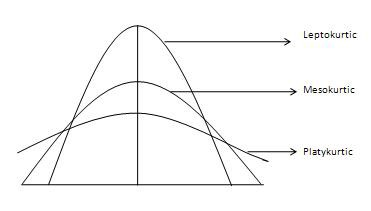

In [26]:
print(wines[columns].kurtosis())

fixed acidity            2.172178
volatile acidity         5.091626
citric acid              6.174901
residual sugar           3.469820
chlorides               37.564600
free sulfur dioxide     11.466342
total sulfur dioxide     0.571853
density                  9.793807
pH                       0.530775
sulphates                1.590930
alcohol                 -0.698425
quality                  0.216526
dtype: float64


Para verificarmos os valores outliers em um grafico, podemos exibir o boxplot de cada variavel para visualizarmos melhor onde estão esses valores. Como visualizado abaixo as variaveis com exceção de 'alcohol' todas as outras possuem outliers. Dessa forma podemos definir como iremos tratar esses dados, removendo eles ou utilizando algum metodo de inputação.

In [27]:
def boxplot_individuais(data, columns):
    for column in columns:
        sns.boxplot(x = data[column])
        plt.show()

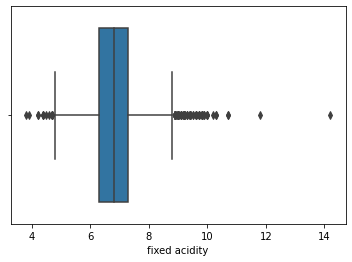

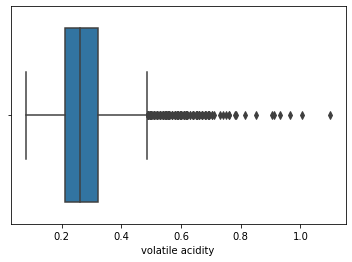

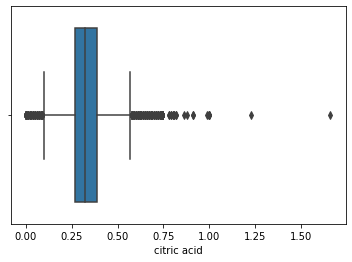

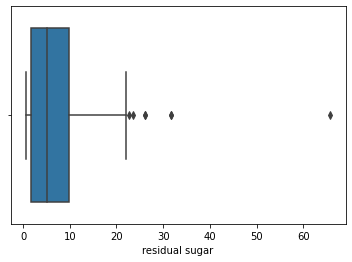

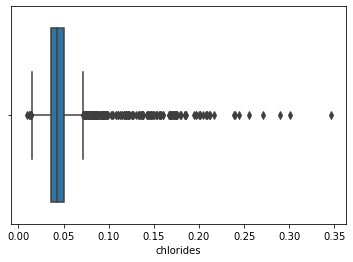

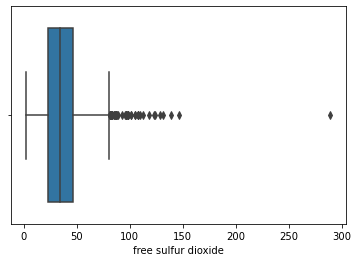

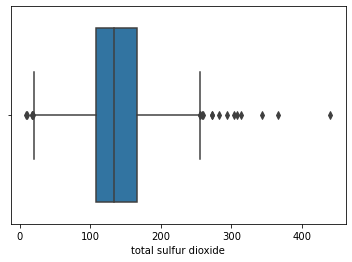

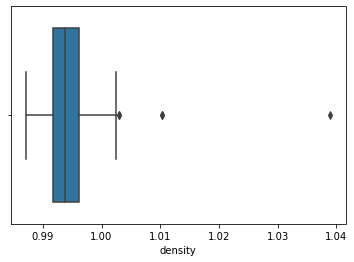

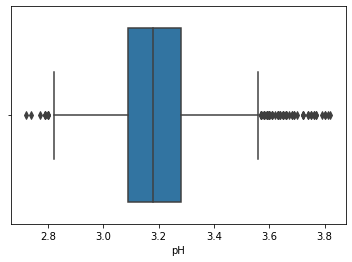

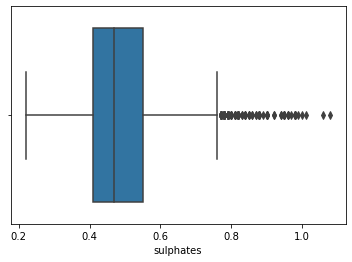

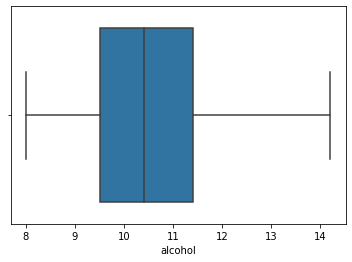

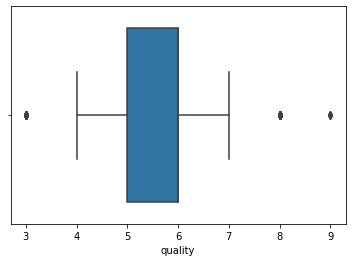

In [28]:
boxplot_individuais(wines, columns)

Para termos uma diferente perspectiva podemos calcular o histograma para cada uma das variaveis e comparar com o skewness para ver se os valores fora do range de -1 e 1 se comportam fora de uma normal. E conforme a analise do skewness os valores  'volatile acidity', 'citric acid', 'chlorides' e 'free sulfur dioxide' estão fora de uma Distribuição Normal Gaussiana. 

In [29]:
def hist_individual(data, columns):
    for column in columns:
        data[column].hist(label = column)
        plt.title(column)
        plt.show()

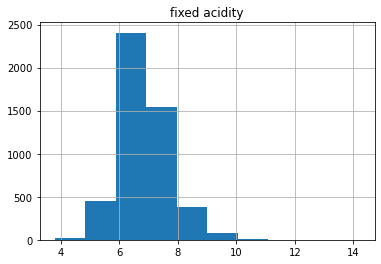

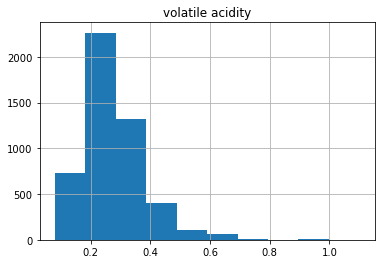

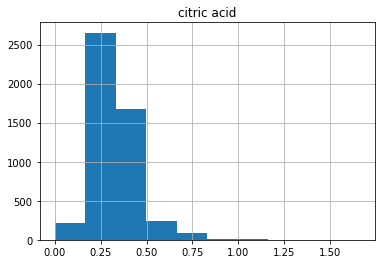

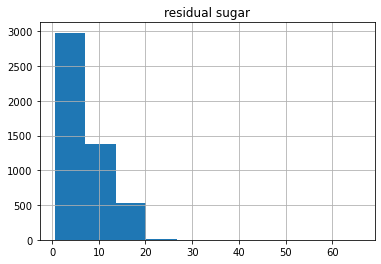

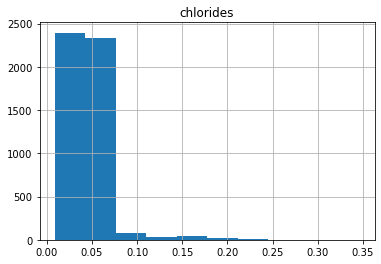

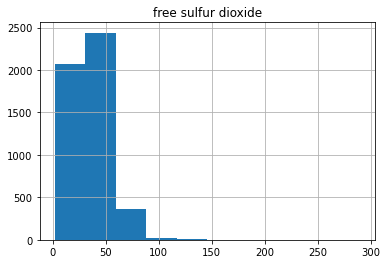

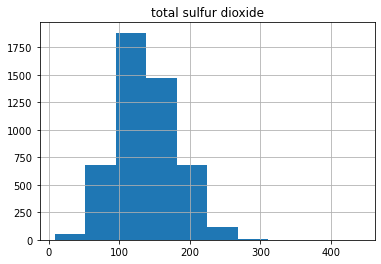

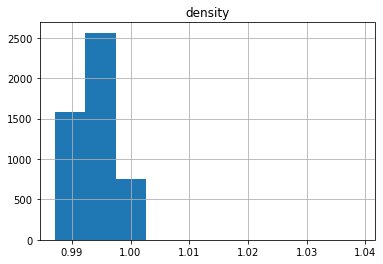

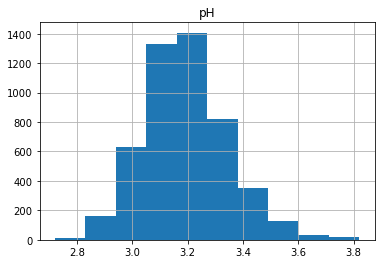

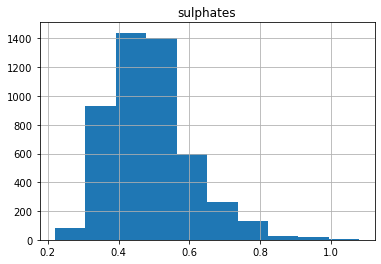

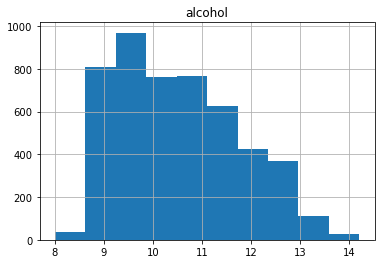

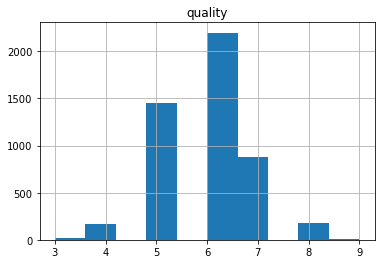

In [30]:
hist_individual(wines, columns)

Após analisarmos os valores outliers e o comportamento do dataset precisamos tratar esses outliers. A melhor forma é tratarmos os dados que possuem uma distruição normal de uma forma e os que não possuem de outra. Para a nossa abordagem iremos utilizar  tecnica de imputação para ambos os casos. Para os valores que seguem a distribuição normal podemos utilizar o calculo de z score delimitando um threshold. Já para as variaveis que não seguem a distribuição normal aplicar a transformação logaritmica.

Porém para essa abordagem, iremos preferir a mesma tecnica para ambos os casos. Assim iremos inputar os valores pela média da variavel (desconsiderando os outliers).

In [31]:
# Criando variavel com todas colunas possuem outlier
outlier_columns = columns.copy().to_list()
outlier_columns.remove('alcohol')
print(outlier_columns)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'quality']


In [32]:
def outlier_percentil_based(data, columns):
    for column in columns:
        # Capturando percentile de 10 e 90
        percentil10 = data[column].quantile(0.10)
        percentil90 = data[column].quantile(0.90)
        
        data[column] = np.where(data[column] < percentil10, percentil10, data[column])
        data[column] = np.where(data[column] > percentil90, percentil90, data[column])
        
    return data


In [33]:
def outlier_log_transformation_based(data, columns):
    for column in columns:
        data[column] = data[column].map(lambda x: np.log(x) if x > 0 else 0)
    return data

In [34]:
def outlier_median_based(data, columns, bottom = False):
    for column in columns:
        percentil50 = data[column].quantile(0.50)
        percentil95 = data[column].quantile(0.95)
        percentil05 = data[column].quantile(0.05)
        
        data[column] = np.where(data[column]  > percentil95, percentil50, data[column])
        
        if bottom:
            data[column] = np.where(data[column]  < percentil05, percentil50, data[column])
        
    return data

In [35]:
wines = outlier_median_based(wines, outlier_columns, bottom =  True)

Após tratarmos os valores outliers é interessante verificarmos novamente o skewness, boxplot e histograma. É perceptivel que os outliers foram removidos, porém os histogramas não demonstram mais o comportamento de uma distribuição normal. Assim iremos ter que gerar novamente uma distribuição normal sobre os dados.

In [36]:
print(wines.skew())

fixed acidity           0.251616
volatile acidity        0.557183
citric acid             0.592357
residual sugar          0.647903
chlorides               0.283003
free sulfur dioxide     0.260288
total sulfur dioxide    0.270364
density                 0.256463
pH                      0.239489
sulphates               0.537369
alcohol                 0.487342
quality                 0.150855
dtype: float64


É notavel que após utilizar a tecnica de imputação para os nossos outliers a kurtosis negativa ou proxima a zero para todas as variaveis. Isso significa que removemos qquase todos os outliers ou que possuimos um baixo numero de outliers. Isso pode ser comprovado analisando o boxplot da nova base.

In [37]:
print(wines.kurtosis())

fixed acidity          -0.366659
volatile acidity       -0.084250
citric acid             0.007458
residual sugar         -0.682921
chlorides              -0.280081
free sulfur dioxide    -0.587664
total sulfur dioxide   -0.630729
density                -0.778132
pH                     -0.416221
sulphates              -0.158999
alcohol                -0.698425
quality                -0.852576
dtype: float64


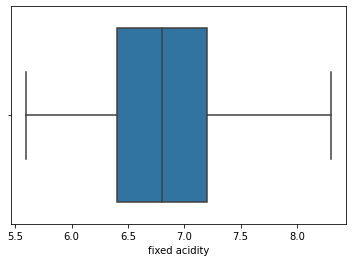

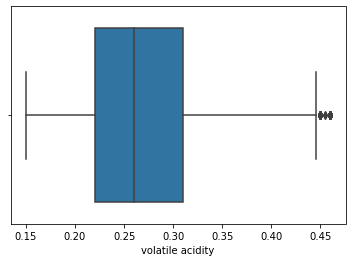

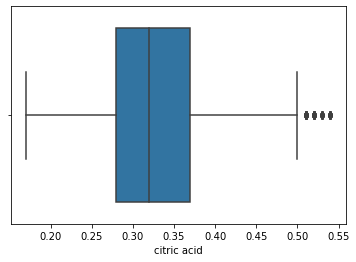

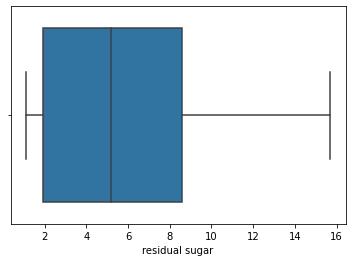

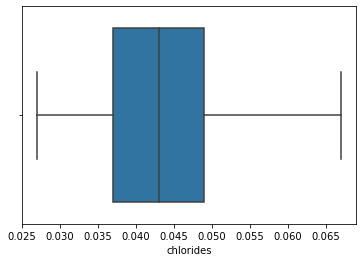

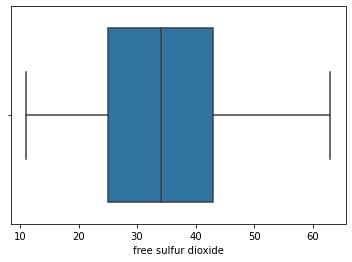

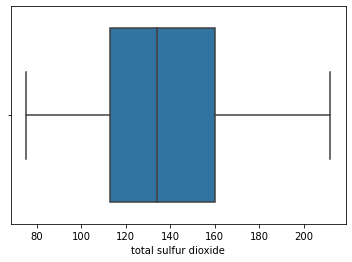

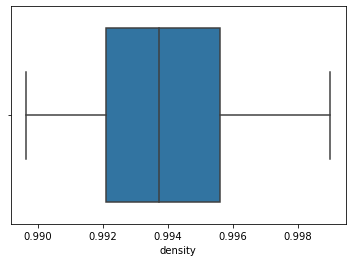

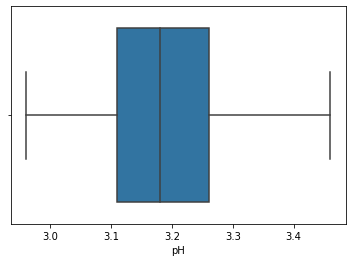

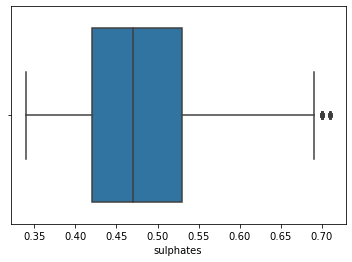

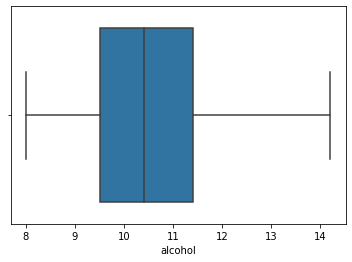

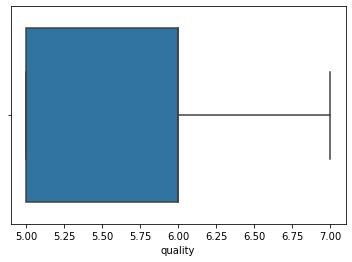

In [38]:
boxplot_individuais(wines, columns)

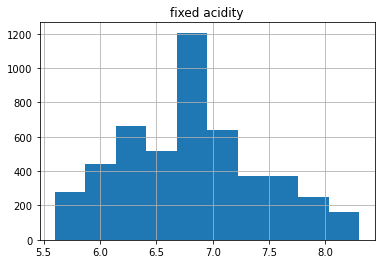

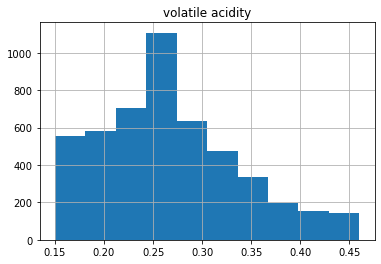

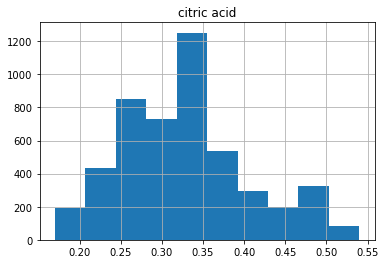

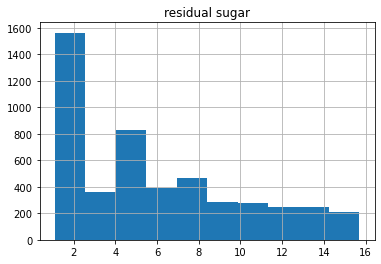

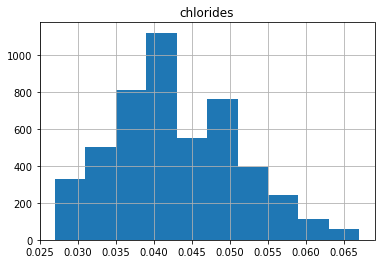

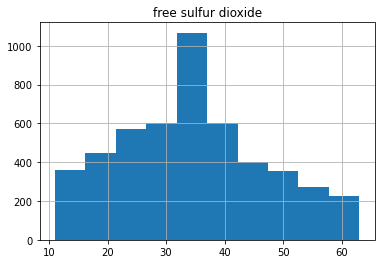

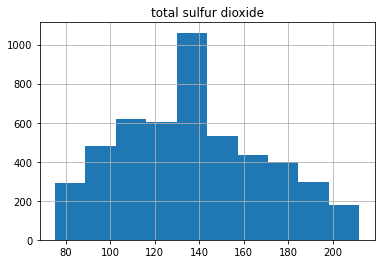

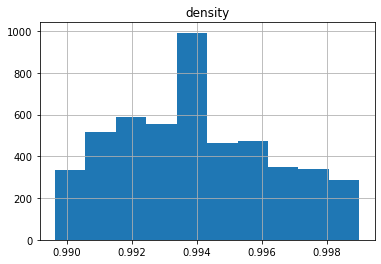

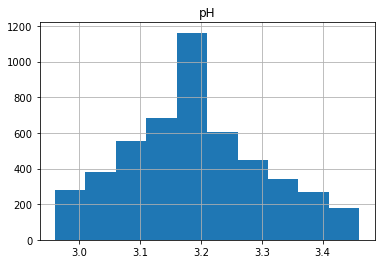

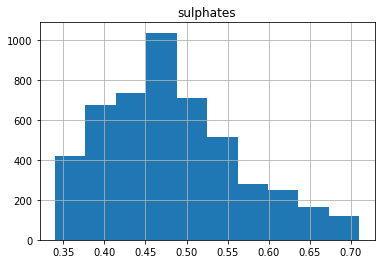

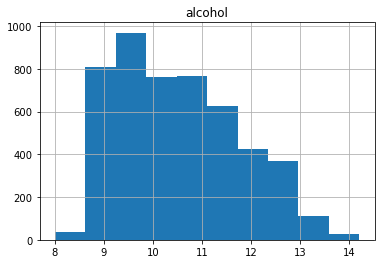

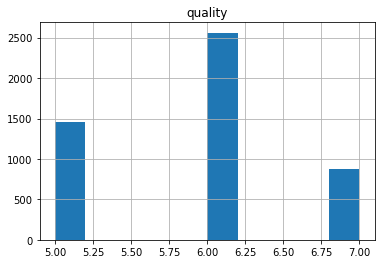

In [39]:
hist_individual(wines, columns)

# Feature Selecting

Para possuirmos um melhor resultado é ideal selecionarmos somente as variaveis necessárias para o nosso modelo, eliminando variaveis que não trazem um ganho significativo, assim podemos eliminar a especificidade consequentemente aumentando a generalização e evitando overfitting. Para isso iremos trazer abaixo as analises que foram feitas ao longo do notebook:

1 - 'residual sugar' e 'alcohol' são muito bem representadas pela variavel 'density'. Trazendo multicolinearidade para o modelo.

2 - 'fixed acidity'apresentou uma boa representatividade sobre a variavel 'pH'. Trazendo multicolinearidade para o modelo.

3 - 'alcohol' é a variavel com maior correlação com a variavel target, 'quality'.

4 - 'citric acid', 'free sulfur dioxide' e 'sulphates' não possuem correlação significativa com a variavel target, 'quality'.


Baseado nas hipoteses acima, iremos criar alguns modelos de Machine Learning da familia ensemble para verificar quais são as variaveis com maior importância.

In [40]:
modelo = xgb.XGBClassifier(n_estimators = 1000)

In [41]:
X = wines.iloc[:, :-1]
y = wines['quality'].values

modelo.fit(X, y)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=24, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
print(modelo.feature_importances_)

[0.07764331 0.1092582  0.0794206  0.07777265 0.07772369 0.08010259
 0.07427387 0.0755174  0.07766463 0.07655106 0.19407198]


In [43]:
index_ordenado = modelo.feature_importances_.argsort()

<BarContainer object of 11 artists>

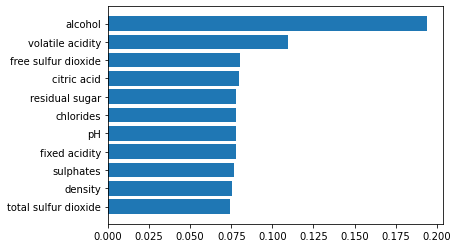

In [44]:
plt.barh(wines.drop('quality', axis = 1).columns[index_ordenado], modelo.feature_importances_[index_ordenado])

Realizando o processo de feature selecting utilizando o algoritmo XGBoost notamos que 'density' possui uma das piores importâncias para o modelo, a variavel citric acid apesar de a analise indicar uma baixa relação foi de grande importância, porém a variavel 'sulphates' e 'free sulfur dioxide' apresentaram baixos resultados como esperado. Para um teste podemos manter  6 das variaveis mais importantes, de um total de 11. Portanto podemos realizar um modelo de teste para verificar seu desempenho.

In [45]:
# Variaveis selecionas antes da padronização
wines = wines[['chlorides', 'residual sugar', 'citric acid', 'free sulfur dioxide', 'volatile acidity', 'alcohol', 'quality']]

# Variaveis selecionadas após a padronização
#wines = wines[['pH', 'chlorides', 'fixed acidity', 'citric acid', 'volatile acidity', 'alcohol', 'quality']]

wines.head()

,chlorides,residual sugar,citric acid,free sulfur dioxide,volatile acidity,alcohol,quality
0,0.045,5.2,0.36,45.0,0.27,8.8,6.0
1,0.049,1.6,0.34,14.0,0.30,9.5,6.0
2,0.050,6.9,0.40,30.0,0.28,10.1,6.0
3,0.058,8.5,0.32,47.0,0.23,9.9,6.0
4,0.058,8.5,0.32,47.0,0.23,9.9,6.0


In [46]:
# Variaveis selecionanas apartir da analise humana
'''
# Removendo colunas 'residual sugar', 'pH' e 'alcohol' para evitar multicolinearidade
wines = wines.drop(['residual sugar', 'pH'], axis = 1)

# Removendo colunas que não possuem alta correlação com a variavel target 'quality'
wines = wines.drop(['citric acid', 'free sulfur dioxide'], axis = 1)
'''

"\n# Removendo colunas 'residual sugar', 'pH' e 'alcohol' para evitar multicolinearidade\nwines = wines.drop(['residual sugar', 'pH'], axis = 1)\n\n# Removendo colunas que não possuem alta correlação com a variavel target 'quality'\nwines = wines.drop(['citric acid', 'free sulfur dioxide'], axis = 1)\n"

## Normalizando/Padronização

Conforme avaliado anteriormente, após os outliers serem tratados foram gerados problemas na normalizaçao. Para isso iremos normalizar os dados novamente. Porém, para normalizarmos os dados precisamos saber quais variaveis serão normalizadas, todas? E a variavel target que iremos entregar no final, necessita de uma normalização? Muito provavelmente não, então iremos removela do dataset antes.

In [47]:
X = wines.iloc[:, :-1]
y = wines['quality'].values

In [48]:
X.head()

,chlorides,residual sugar,citric acid,free sulfur dioxide,volatile acidity,alcohol
0,0.045,5.2,0.36,45.0,0.27,8.8
1,0.049,1.6,0.34,14.0,0.30,9.5
2,0.050,6.9,0.40,30.0,0.28,10.1
3,0.058,8.5,0.32,47.0,0.23,9.9
4,0.058,8.5,0.32,47.0,0.23,9.9


In [49]:
print(y)

[6. 6. 6. ... 6. 7. 6.]


In [50]:
# Normalização
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
print(X_scaled)

[[ 0.22249857 -0.17103245  0.4192587   0.84562416  0.01863979 -1.39315246]
 [ 0.69927775 -1.03862093  0.16155284 -1.64831341  0.4520149  -0.82427568]
 [ 0.81847254  0.23866211  0.93467042 -0.36111982  0.16309816 -0.33666701]
 ...
 [-0.25428061 -1.13501965 -1.77124108 -0.36111982 -0.41473532 -0.90554379]
 [-0.01589102 -1.15911933 -0.35385887 -1.16561581  0.30755653  1.85757201]
 [-0.01589102 -0.17103245  0.67696456 -1.00471661 -0.84811044  1.04489089]]


(array([ 439.,  396.,  814., 1123.,  723.,  592.,  394.,  245.,  113.,
          59.]),
 array([-1.92300773, -1.44622855, -0.96944937, -0.4926702 , -0.01589102,
         0.46088816,  0.93766734,  1.41444652,  1.8912257 ,  2.36800487,
         2.84478405]),
 <BarContainer object of 10 artists>)

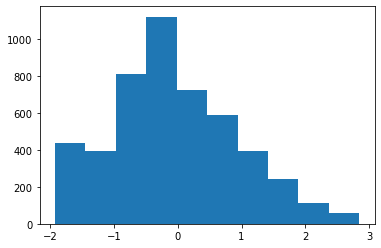

In [52]:
plt.hist(X_scaled[:,0:1])

## Transformando os Dados

Após normalizarmos as variaveis independentes (X), iremos transformar a nossa variavel dependente (y) que é continua em qualitativa numérica. Todos valores de y igual ou acima a 6.5 irão ser transformados em 1 e o restante em 0.

In [53]:
y_list = []

In [54]:
# Valores acima de 6.5 serão classificados como Bom, ou seja 1. Valores abaixo de 6.5 serão Ruim, ou seja 0.

for i in range(0, len(y)):
    if y[i] >= 6.5:
        y_list.append(1) # Good
    else:
        y_list.append(0) # Bad

In [55]:
print(y_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Após a conversão para uma classe binária entre 0 e 1 precisamos verificar o balanceamento do dataset que conforme abaixo está totalmente desbalanceado, com um numero muito maior para classificação de 'Bad'. Isso se dá pois claramente possuiamos muitos valores abaixo de 6.5, principalmente entre  6.0 e 6.25.

In [56]:
print(Counter(y))

Counter({6.0: 2561, 5.0: 1457, 7.0: 880})


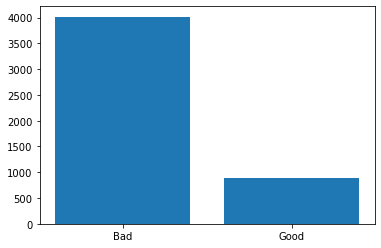

In [57]:
plt.bar(['Bad', 'Good'], [y_list.count(0), y_list.count(1)])
plt.show()

In [58]:
y = np.array(y_list)

In [59]:
print(y)

[0 0 0 ... 0 1 0]


## BALANCEANDO OS DADOS

## OVERSAMPLING BASICO

O Oversampling na sua forma mais crua, replicando os dados da amostra inicial, não será utilizado pois já foi documentado que não apresenta ganho significativo de precisão.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .3)

In [ ]:
count_class_0 = Counter(y_train)[0]
count_class_1 = Counter(y_train)[1]

In [ ]:
print(count_class_0, count_class_1)

In [ ]:
dt_final = pd.DataFrame(x_train)
dt_final['quality'] = y_train
dt_final.head()

In [ ]:
dt_final.shape

In [ ]:
dt_class_0 = dt_final[dt_final['quality'] == 0]
dt_class_1 = dt_final[dt_final['quality'] == 1]

In [ ]:
dt_class_1_over = dt_class_1.sample(count_class_0, replace = True)

In [ ]:
print(dt_class_0.shape, dt_class_1_over.shape)

In [ ]:
dt_class_0 = dt_class_0.reset_index(drop = True)
dt_class_1_over = dt_class_1_over.reset_index(drop = True)

In [ ]:
dt_final = pd.concat([dt_class_0, dt_class_1_over], axis = 0)

In [ ]:
dt_final.shape

In [ ]:
dt_final.head()

In [ ]:
x_train = dt_final.iloc[:, :-1]
y_train = dt_final['quality'].values

## SMOTE

In [60]:
#x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .3, stratify = y)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .1)

In [61]:
print(Counter(y_train))
print(x_train.shape)

Counter({0: 3624, 1: 784})
(4408, 6)


In [62]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [63]:
print(Counter(y_train))
print(x_train.shape)

Counter({0: 3624, 1: 3624})
(7248, 6)


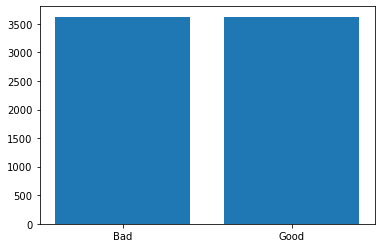

In [64]:
plt.bar(['Bad', 'Good'], [list(y_train).count(0), list(y_train).count(1)])
plt.show()

In [65]:
print(len(x_train), len(x_test))

7248 490


# Treinando Modelos

In [66]:
def report_modelo(modelo, y, pred, label = 'Modelo', save = False):
    target_names = ['Bad',  'Good']
    
    # Forçando predições para um numero inteiro, visto que não faz sentido manter a probabilidade
    pred[pred >  0.5] = 1
    pred[pred <=  0.5] = 0
    
    # Plotando a matriz de confusão
    cm = confusion_matrix(y, pred)
    cm = pd.DataFrame(cm, index = target_names, columns= target_names)

    plt.figure(figsize = (10, 10))
    sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidths = 1, annot = True, \
                fmt = '', xticklabels = target_names, yticklabels = target_names)
    plt.show()
    
    print('AUC: %f' % roc_auc_score(y_true = y, y_score = pred))
    
    # Area sob  a curva ROC
    rfp, rvp, lim = roc_curve(y_true = y, y_score = pred)

    plt.plot(rfp, rvp, marker = '.',  label = label,  color = 'orange')
    plt.plot([0, 1],  [0, 1], color = 'darkblue', linestyle = '--')
    plt.xlabel('Especificade')
    plt.ylabel('Sensibilidade')
    plt.legend()
    plt.show()
    
    print("Acurácia: %f" % accuracy_score(y_true = y, y_pred = pred))
    
    print(classification_report(y_true = y, y_pred = pred, target_names= target_names))
    
    if save:
        shortFileName = '000'
        fileName = 'models/0001.model'
        fileObj = Path(fileName)
        
        index = 1
        while fileObj.exists():
            index += 1
            fileName = 'models/' + shortFileName + str(index) + '.model'
            fileObj = Path(fileName)
        
        # salvar modelo
        pickle.dump(modelo, open(fileName, 'wb'))
        
        return fileName

## Redes Neurais - MLPClassifier

In [67]:
###### CRIANDO VERSÃO 01 DO MODELO
modelo_v1 = MLPClassifier(max_iter = 1000, verbose = False)
modelo_v1.fit(x_train, y_train)
preds = modelo_v1.predict(x_test)

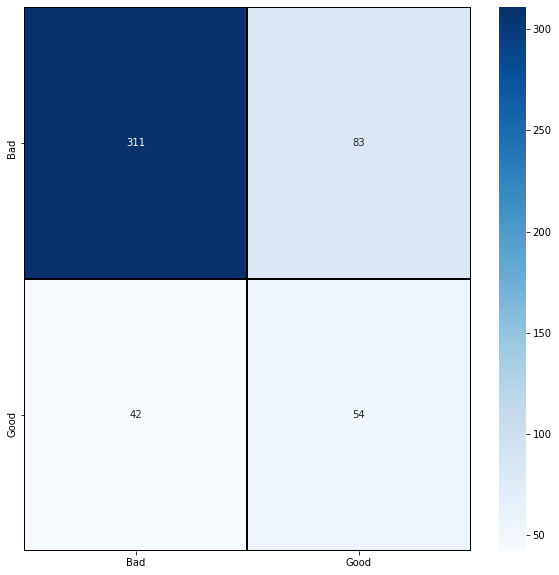

AUC: 0.675920


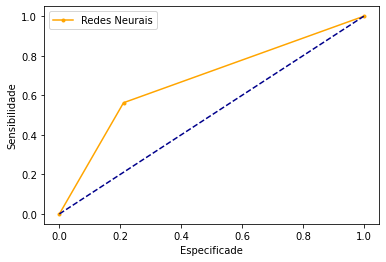

Acurácia: 0.744898
              precision    recall  f1-score   support

         Bad       0.88      0.79      0.83       394
        Good       0.39      0.56      0.46        96

    accuracy                           0.74       490
   macro avg       0.64      0.68      0.65       490
weighted avg       0.79      0.74      0.76       490



In [68]:
report_modelo(modelo_v1, y_test, preds, 'Redes Neurais')

In [ ]:
###### CRIANDO VERSÃO 02 DO MODELO
# Definindo parametros e configurações

'''
params = {
        'hidden_layer_sizes': [[100, 100], [100, 100, 100], [100, 100, 100, 100]],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
        'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
        'max_iter': [500, 1000, 2000],
        'momentum': [1.0, 0.9, 0.8],
        'tol': [0.00001],
        'verbose': [False],
        'early_stopping': [True, False],
        'random_state': [102]
        }'''

params = {
        'hidden_layer_sizes': [[100, 100], [100, 100, 100]],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [0.00001, 0.0001, 0.001],
        'learning_rate_init': [0.0001, 0.001, 0.01],
        'max_iter': [1000],
        'momentum': [1.0, 0.9, 0.8],
        'tol': [0.00001],
        'verbose': [False],
        'early_stopping': [True, False],
        'random_state': [102]
        }

#  Parametros de teste
'''
params = {
        'momentum': [1.0, 0.9, 0.8],    
        'tol': [0.00001],
        'max_iter': [1000],
        'verbose': [True],
        'early_stopping': [False],
        'hidden_layer_sizes': [[100, 100]],
        'random_state': [102]
        }'''

grid = GridSearchCV(MLPClassifier(), params, n_jobs = 20)

grid.fit(x_train, y_train)

preds = grid.predict_proba(x_test)[:,1]

modelo = grid.best_estimator_

In [ ]:
report_modelo(modelo, y_test, preds, 'Redes Neurais')

print(grid.best_params_)

# salvar modelo
pickle.dump(modelo, open('models/000x.model', 'wb'))

In [ ]:
# carregar modelo
modelo_carregado = pickle.load(open('models/000x.model', 'rb'))
preds = modelo_carregado.predict(x_test)

fileName = report_modelo(modelo_carregado, y_test, preds, 'Redes Neurais', True)
print(fileName)

In [ ]:
###### CRIANDO VERSÃO 2.1 DO MODELO
# Definindo parametros e configurações

params = {
        'hidden_layer_sizes': [[100, 100], [100, 100, 100], [100, 100, 100, 100]],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.0001, 0.001, 0.01],
        'max_iter': [2000],
        'momentum': [1.0, 0.9],
        'tol': [0.00001],
        'verbose': [False],
        'early_stopping': [False],
        'random_state': [102]
        }

grid = GridSearchCV(MLPClassifier(), params, n_jobs = 20)

grid.fit(x_train, y_train)

preds = grid.predict_proba(x_test)[:,1]

modelo = grid.best_estimator_

In [ ]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [69]:
###### CRIANDO VERSÃO 03 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-06, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.01, max_iter = 1000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-05, verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

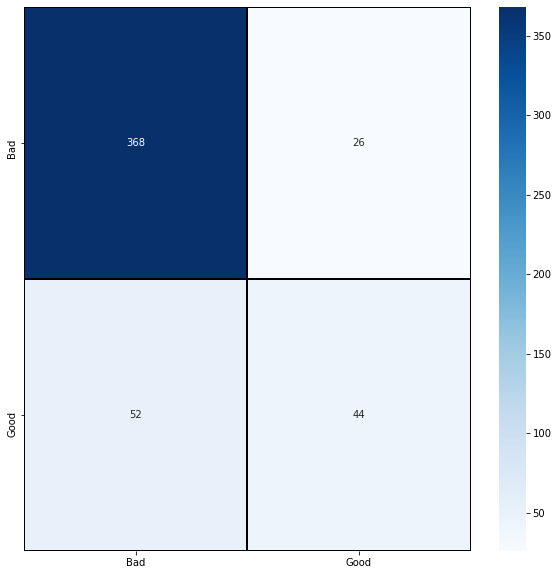

AUC: 0.696172


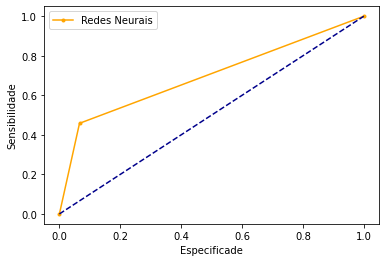

Acurácia: 0.840816
              precision    recall  f1-score   support

         Bad       0.88      0.93      0.90       394
        Good       0.63      0.46      0.53        96

    accuracy                           0.84       490
   macro avg       0.75      0.70      0.72       490
weighted avg       0.83      0.84      0.83       490



'models/0001.model'

In [81]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [82]:
###### CRIANDO VERSÃO 04 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.01, max_iter = 1000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-05, verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

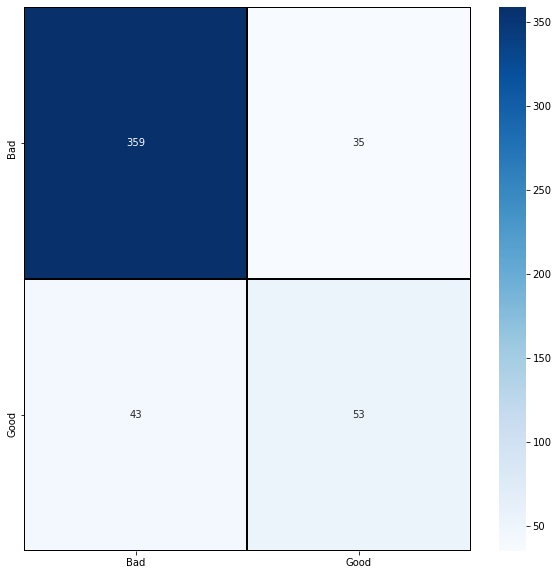

AUC: 0.731625


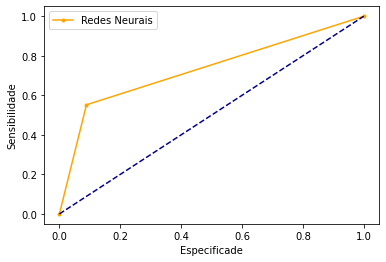

Acurácia: 0.840816
              precision    recall  f1-score   support

         Bad       0.89      0.91      0.90       394
        Good       0.60      0.55      0.58        96

    accuracy                           0.84       490
   macro avg       0.75      0.73      0.74       490
weighted avg       0.84      0.84      0.84       490



'models/0002.model'

In [83]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [84]:
###### CRIANDO VERSÃO 05 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.0035, max_iter = 1000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-10, verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

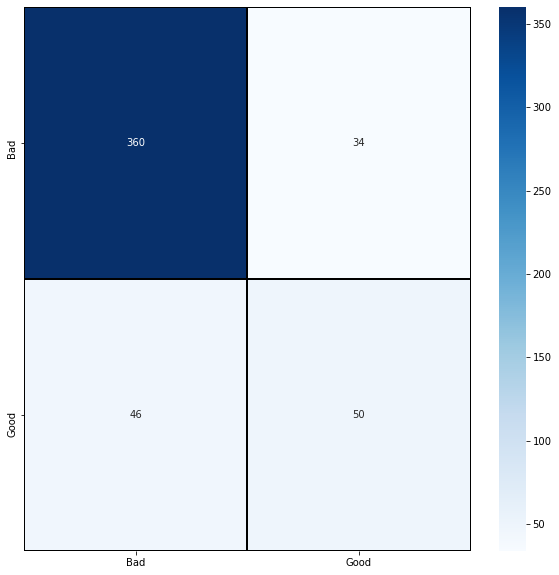

AUC: 0.717269


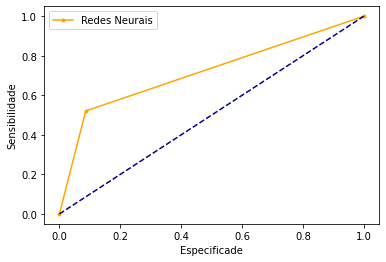

Acurácia: 0.836735
              precision    recall  f1-score   support

         Bad       0.89      0.91      0.90       394
        Good       0.60      0.52      0.56        96

    accuracy                           0.84       490
   macro avg       0.74      0.72      0.73       490
weighted avg       0.83      0.84      0.83       490



'models/0003.model'

In [85]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [86]:
###### CRIANDO VERSÃO 06 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.0050, max_iter = 1000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-10, verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

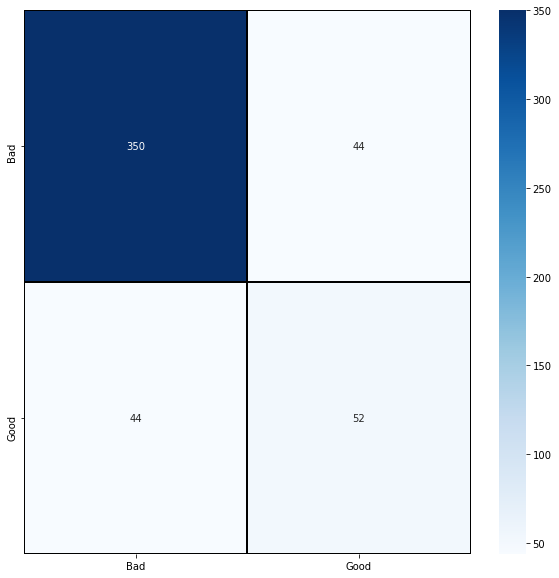

AUC: 0.714996


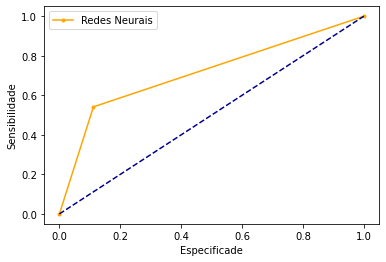

Acurácia: 0.820408
              precision    recall  f1-score   support

         Bad       0.89      0.89      0.89       394
        Good       0.54      0.54      0.54        96

    accuracy                           0.82       490
   macro avg       0.71      0.71      0.71       490
weighted avg       0.82      0.82      0.82       490



'models/0004.model'

In [87]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [88]:
shap.initjs()

explainer = shap.KernelExplainer(modelo.predict_proba, x_train)
shap_values = explainer.shap_values(x_test[0:100,:])

Using 7248 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

In [89]:
column_names = ['chlorides', 'residual sugar', 'citric acid', 'free sulfur dioxide', 'volatile acidity', 'alcohol']

In [90]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_test[0,], feature_names = column_names)

In [91]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test[0:100,:], feature_names = column_names)

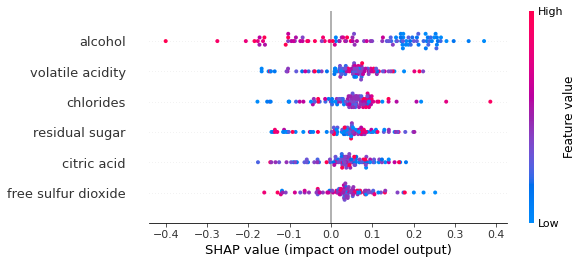

In [92]:
shap.summary_plot(shap_values[0], x_test[0:100,:], feature_names = column_names)

In [93]:
###### CRIANDO VERSÃO 07 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.0025, max_iter = 2000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-10, verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

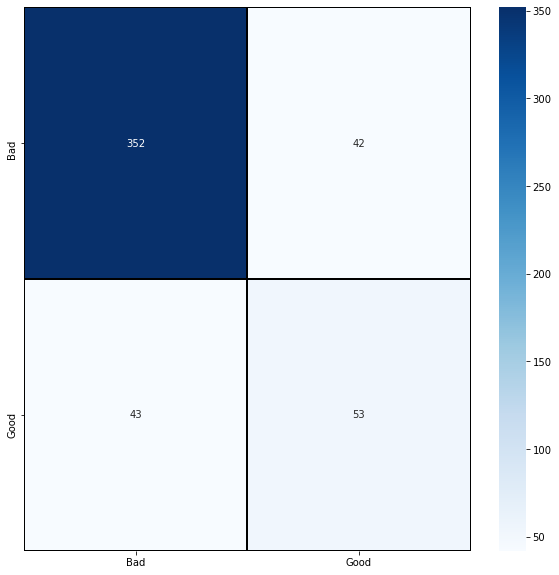

AUC: 0.722742


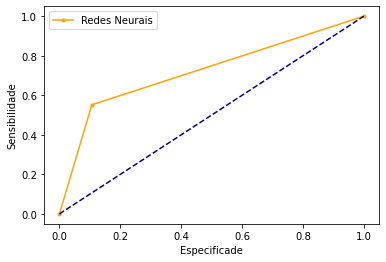

Acurácia: 0.826531
              precision    recall  f1-score   support

         Bad       0.89      0.89      0.89       394
        Good       0.56      0.55      0.55        96

    accuracy                           0.83       490
   macro avg       0.72      0.72      0.72       490
weighted avg       0.83      0.83      0.83       490



'models/0005.model'

In [94]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [95]:
###### CRIANDO VERSÃO 08 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.0025, max_iter = 5000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-10, n_iter_no_change = 100, \
                       verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

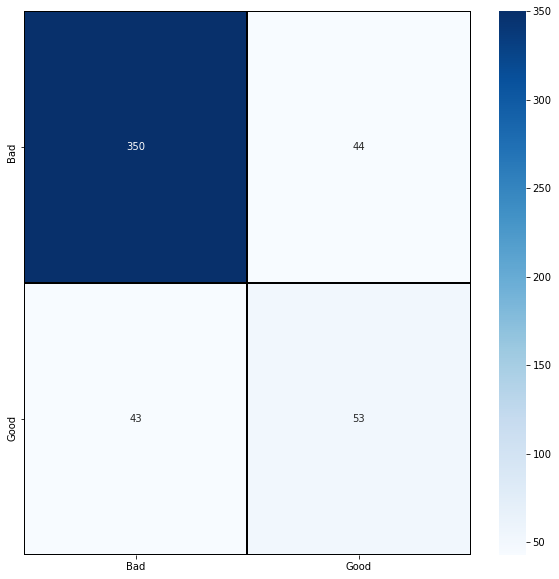

AUC: 0.720204


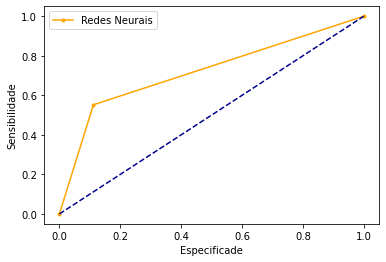

Acurácia: 0.822449
              precision    recall  f1-score   support

         Bad       0.89      0.89      0.89       394
        Good       0.55      0.55      0.55        96

    accuracy                           0.82       490
   macro avg       0.72      0.72      0.72       490
weighted avg       0.82      0.82      0.82       490



'models/0006.model'

In [96]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [97]:
###### CRIANDO VERSÃO 09 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.0025, max_iter = 5000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-10, n_iter_no_change = 100, \
                       verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

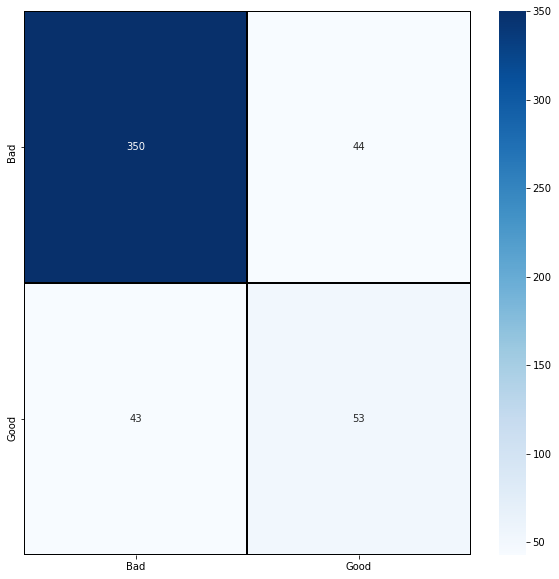

AUC: 0.720204


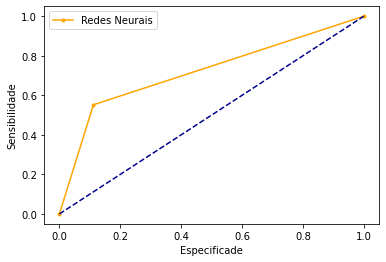

Acurácia: 0.822449
              precision    recall  f1-score   support

         Bad       0.89      0.89      0.89       394
        Good       0.55      0.55      0.55        96

    accuracy                           0.82       490
   macro avg       0.72      0.72      0.72       490
weighted avg       0.82      0.82      0.82       490



'models/0007.model'

In [98]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [99]:
###### CRIANDO VERSÃO 10 DO MODELO

modelo = MLPClassifier(activation = 'logistic', alpha = 1e-07, early_stopping = False,\
                       hidden_layer_sizes = [100, 100], learning_rate_init = 0.001, max_iter = 5000,\
                       momentum = 1.0, random_state = 102, solver = 'adam', tol = 1e-20, n_iter_no_change = 250, \
                       verbose = False)
modelo.fit(x_train, y_train)
preds = modelo.predict(x_test)

Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.


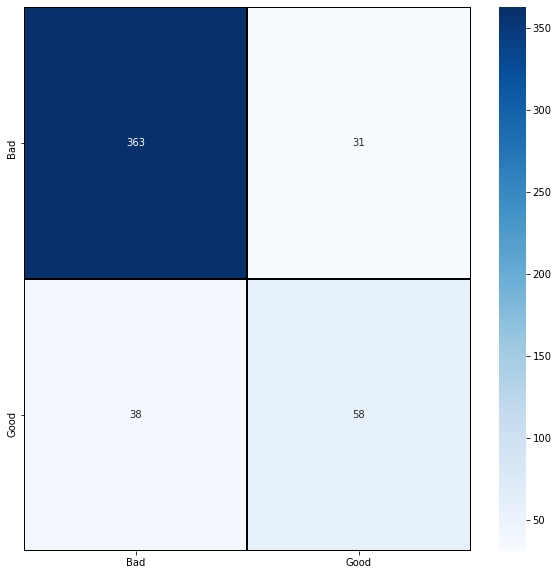

AUC: 0.762743


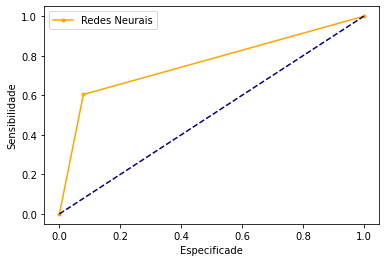

Acurácia: 0.859184
              precision    recall  f1-score   support

         Bad       0.91      0.92      0.91       394
        Good       0.65      0.60      0.63        96

    accuracy                           0.86       490
   macro avg       0.78      0.76      0.77       490
weighted avg       0.86      0.86      0.86       490



'models/0008.model'

In [100]:
report_modelo(modelo, y_test, preds, 'Redes Neurais', True)

In [101]:
shap.initjs()

explainer = shap.KernelExplainer(modelo.predict_proba, x_train)
shap_values = explainer.shap_values(x_test[0:100,:])

Using 7248 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

In [106]:
column_names = ['chlorides', 'residual sugar', 'citric acid', 'free sulfur dioxide', 'volatile acidity', 'alcohol']

In [107]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_test[0,], feature_names = column_names)

In [108]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test[0:100,:], feature_names = column_names)

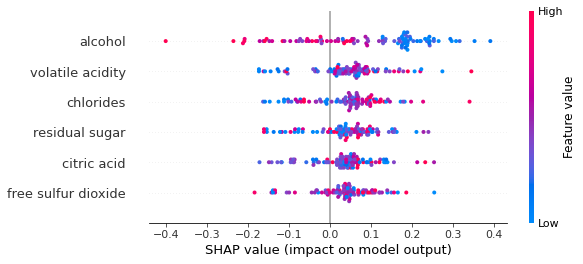

In [109]:

shap.summary_plot(shap_values[0], x_test[0:100,:], feature_names = column_names)

## XGBOOST

In [71]:
# Transformando os dados em DMatrix pois o XGBoost exige
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)

In [72]:
# Definindo parametros e configurações
param = {}
num_round = 2

In [73]:
# Treinando versão 1
modelo_v1 = xgb.train(params = param, dtrain = dtrain)

In [74]:
# Realizando previsões
preds = modelo_v1.predict(dtest)

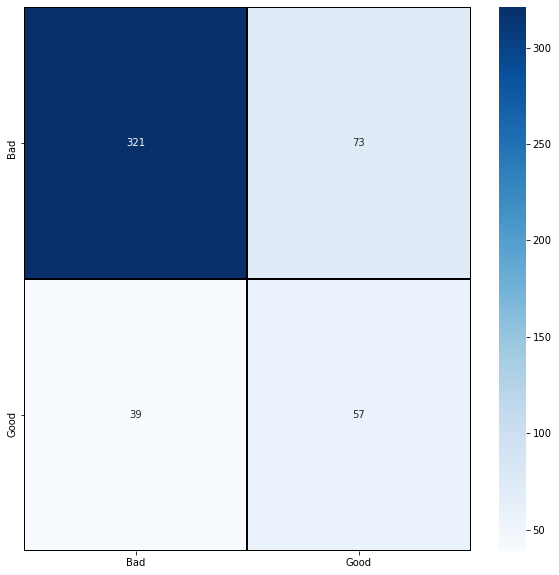

AUC: 0.704235


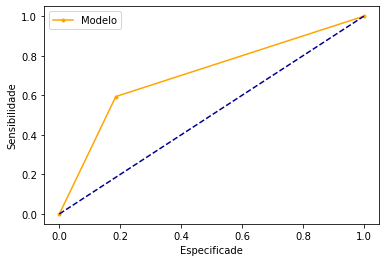

Acurácia: 0.771429
              precision    recall  f1-score   support

         Bad       0.89      0.81      0.85       394
        Good       0.44      0.59      0.50        96

    accuracy                           0.77       490
   macro avg       0.67      0.70      0.68       490
weighted avg       0.80      0.77      0.78       490



In [75]:
report_modelo(modelo_v1, y_test, preds)

In [76]:
# Definindo parametros e configurações
param = {'nthread':  20}
num_round = 100

In [77]:
# Treinando versão 2
modelo_v2 = xgb.train(params = param, dtrain = dtrain, num_boost_round = num_round)

In [78]:
# Realizando previsões
preds = modelo_v2.predict(dtest)

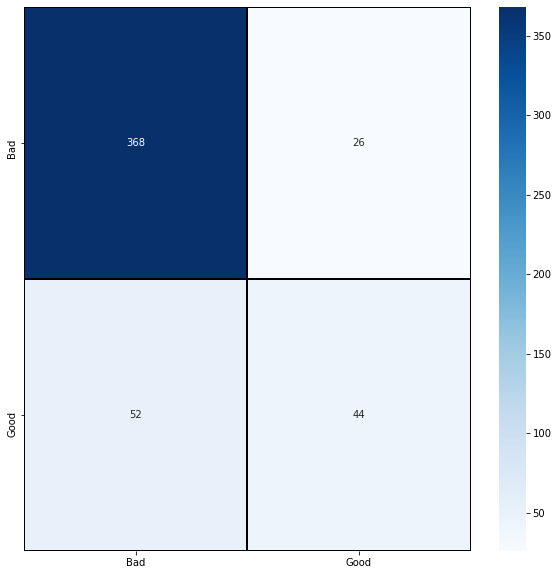

AUC: 0.696172


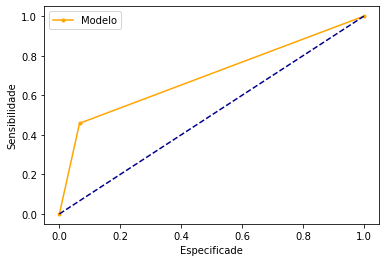

Acurácia: 0.840816
              precision    recall  f1-score   support

         Bad       0.88      0.93      0.90       394
        Good       0.63      0.46      0.53        96

    accuracy                           0.84       490
   macro avg       0.75      0.70      0.72       490
weighted avg       0.83      0.84      0.83       490



In [79]:
report_modelo(modelo_v2, y_test, preds)

In [80]:
print(y_train)

[0 0 0 ... 1 1 1]


In [ ]:
# Definindo parametros e configurações

param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.3, 0.2, 0.1, 0.05],
        'nthread': [2],
        'num_round': [100]
        }

'''
param = {
        'nthread': [1],
        'num_round': [3]
        }
'''

num_round = 100

# Treinando versão 3
modelo = xgb.XGBClassifier(use_label_encoder = False)

grid = GridSearchCV(modelo, param_grid = param,  n_jobs = 20, scoring='roc_auc')

grid.fit(x_train, y_train)

preds = grid.predict_proba(x_test)[:,1]

modelo = grid.best_estimator_

report_modelo(modelo, y_test, preds)

print(grid.best_params_)

modelo.save_model('models/0002.model')

In [ ]:
modelo = xgb.Booster({'nthread': 4})  # init model
modelo.load_model('models/0001.model')  # load data

In [ ]:
preds = modelo.predict(dtest)

print(preds)

report_modelo(modelo, y_test, preds)

In [ ]:
# Definindo parametros e configurações

param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0, 1.2, 1.4],
        'colsample_bytree': [0.8, 1.0, 1.2, 1.4],
        'max_depth': [4, 5, 6, 7],
        'learning_rate': [0.4, 0.3, 0.2, 0.1],
        'nthread': [2],
        'num_round': [100]
        }

'''
param = {
        'nthread': [1],
        'num_round': [3]
        }
'''

num_round = 100

# Treinando versão 4
modelo = xgb.XGBClassifier(use_label_encoder = False)

grid = GridSearchCV(modelo, param_grid = param,  n_jobs = 20, scoring='roc_auc')

grid.fit(x_train, y_train)

preds = grid.predict_proba(x_test)[:,1]

modelo = grid.best_estimator_

report_modelo(modelo, y_test, preds)

print(grid.best_params_)

modelo.save_model('models/0003.model')

In [ ]:
# Definindo parametros e configurações

param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.125, 0.25, 0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0, 1.2],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [5, 6, 7, 8, 9],
        'learning_rate': [0.4, 0.3, 0.2, 0.1],
        'nthread': [2],
        'num_round': [100]
        }

# Treinando versão 5
modelo = xgb.XGBClassifier(use_label_encoder = False)

grid = GridSearchCV(modelo, param_grid = param,  n_jobs = 20, scoring='roc_auc')

grid.fit(x_train, y_train)

preds = grid.predict_proba(x_test)[:,1]

modelo = grid.best_estimator_

report_modelo(modelo, y_test, preds)

print(grid.best_params_)

modelo.save_model('models/0004.model')

In [ ]:
# Definindo parametros e configurações
param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.125, 0.25, 0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0, 1.2],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0, 1.1],
        'max_depth': [6, 7, 8, 9, 10, 11],
        'learning_rate': [0.4, 0.3, 0.2, 0.1],
        'nthread': [2],
        'num_round': [100]
        }

# Treinando versão 5
modelo = xgb.XGBClassifier(use_label_encoder = False)

grid = GridSearchCV(modelo, param_grid = param,  n_jobs = 20, scoring='roc_auc')

grid.fit(x_train, y_train)

preds = grid.predict_proba(x_test)[:,1]

modelo = grid.best_estimator_

report_modelo(modelo, y_test, preds)

print(grid.best_params_)

modelo.save_model('models/0005.model')